# **AIMS Image Completion with Low Rank Matrix and Tensor Factorization**
Pratical Lab Session 2 | Date: 21, July, 2020

Author: Tianyu Li


### Import packages


In [1]:
import scipy.io
import pylab as plt
import random
import numpy as np
import torch
!pip install tensorly
import tensorly as tl
tl.set_backend('pytorch')
import PIL
from PIL import Image
import torch.optim 
!wget -nc https://insidetheperimeter.ca/wp-content/uploads/2015/11/Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg




     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 163kB 7.7MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100156 sha256=f74781a1796bd122ca42b04630d866dd171462cc8698b2b897b13bc45a8d04cc
  Stored in directory: /root/.cache/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly
--2020-07-21 19:35:04--  https://insidetheperimeter.ca/wp-content/uploads/2015/11/Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg
Resolving insidetheperimeter.ca (insidetheperimeter.ca)... 172.67.197.115, 104.27.165.116, 104.27.164.116, ...
Connecting to insidetheperimeter.ca (insidetheperimeter.ca)|172.67.197.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130517 (127K) [image/jpeg]
Saving to: ‘Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg’

Albert_einstein_by_ 100%[===================>] 127.46K   321KB/s    in 0.4s    

2020-07-21 19:35:05 (321 KB/s) - ‘

### Load image and generate dataset

Here the dataset is a set of observed pixels from the image (`obs_entries_indices, obs_entries_pixels`).


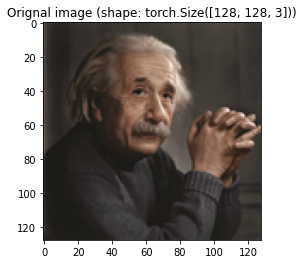

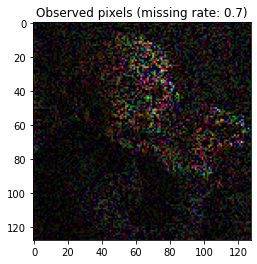

In [2]:
def extract_observed_entries(tensor, missing_rate):
    shape = tensor.shape
    n_pixels = np.prod(shape)
    idx = random.sample(range(n_pixels),int((1-missing_rate)*n_pixels))
    obs_entries = np.unravel_index(idx,shape)
    obs_entries_indices = np.array(obs_entries)
    obs_entries_pixels = tensor[obs_entries]
    ret = [obs_entries_indices,obs_entries_pixels]

    masked_tensor = np.zeros(tensor.shape)
    masked_tensor[obs_entries] = tensor[obs_entries]
    ret.append(masked_tensor)
    return ret

missing_rate = 0.7

image = PIL.Image.open('Albert_einstein_by_zuzahin-d5pcbug-WikiCommons.jpg')
image.thumbnail((200,128),Image.ANTIALIAS)

image = tl.tensor(np.array(image), dtype=torch.float)
image = image[:,:128,:]

obs_entries_indices,obs_entries_pixels,image_missing = extract_observed_entries(image,missing_rate)
data = obs_entries_indices,obs_entries_pixels

plt.figure()
plt.imshow(image/255)
plt.title(f'Orignal image (shape: {image.shape})')
plt.figure()
plt.imshow(image_missing/255,cmap='gray')
plt.title(f'Observed pixels (missing rate: {missing_rate})')
plt.show()


Loss function:
$$\mathcal{L}(T) = \frac{1}{|\Omega|} \sum_{(i_1,i_2,i_3)\in\Omega} (T_{i_1i_2i_3}-X_{i_1i_2i_3})^2$$
where $\Omega$ is the set of indices of observed pixels and $X$ is the original image.

In [3]:
def compute_completion_loss(tensor, data):
    idx, vals = data
    return 1/len(vals) * torch.dist(tensor[idx].reshape(1, -1),vals)



### Completion with low rank matrix factorization

Here is an example of how to use Tensorly+pytorch to solve a matrix completion problem.  We treat the input image tensor as matrix by reshaping the tensor into a two dimensional matrix. Then weuse pytorch to construct a low rank matrix factorization structure and use gradient descent to train this structure and get the completed matrix but doing simple matrix multiplication. Note here we assume the first matricization of the recovered image must be of low matrix rank.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.06384096294641495		 total loss (whole image): 0.05914560705423355


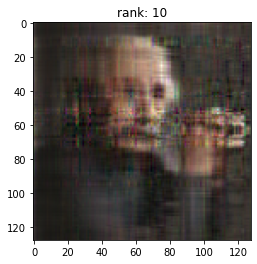

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.026261311024427414		 total loss (whole image): 0.06126600503921509


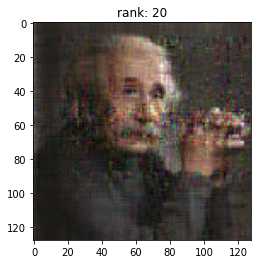

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.005840138997882605		 total loss (whole image): 0.05655417591333389


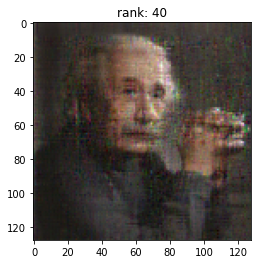

final training loss: 0.009716441854834557		 total loss (whole image): 0.05197075009346008


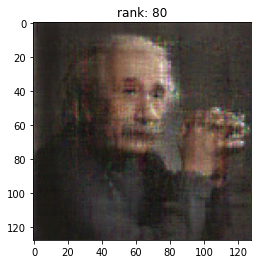

In [4]:
for rank in [10,20,40,80]:
  max_epochs = 1000
  init_std = 0.1
  matrix_shape = [image.shape[0],image.shape[1]*image.shape[2]]
  A = torch.randn(matrix_shape[0],rank)*init_std
  B = torch.randn(rank,matrix_shape[1])*init_std
  A.requires_grad_(True)
  B.requires_grad_(True)

  optim = torch.optim.RMSprop([A,B],lr=0.01)
  for epoch in range(max_epochs):
      loss = compute_completion_loss((A @ B).reshape(image.shape), data)
      optim.zero_grad()
      loss.backward()
      optim.step()

  recovered_image = (A@B).reshape(image.shape).detach()
  total_loss = 1/recovered_image.numel() * torch.dist(recovered_image,image)
  print(f"final training loss: {loss}\t\t total loss (whole image): {total_loss}")
  plt.title(f"rank: {rank}")
  plt.imshow(recovered_image/255)
  plt.show()

### Completion with low rank tensor train factorization

Use the preivous example, implement a Pytorch-based tensor train completion method for the given image. Try to explore with the rank of the tensor train strucutre to obtain the best result. Plot the relationship between the loss and number of parameters of the constructed TT structure. In addition, plot the completed images for each rank you have tried. Note here we assume the recovered image must be of low tensor train rank.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.060114506632089615	total loss (whole image): 0.05807800590991974	number of parameters: 14110


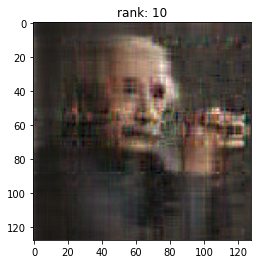

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.04087533429265022	total loss (whole image): 0.055537864565849304	number of parameters: 30765


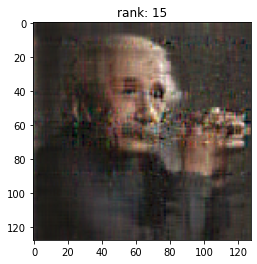

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.029142815619707108	total loss (whole image): 0.05236305296421051	number of parameters: 53820


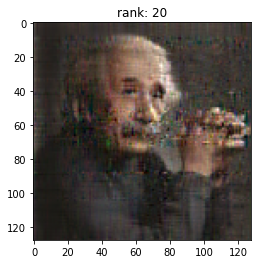

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.03184562176465988	total loss (whole image): 0.053617458790540695	number of parameters: 210040


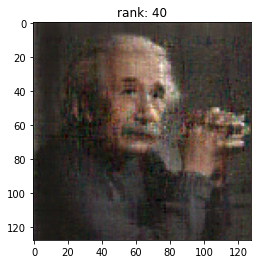

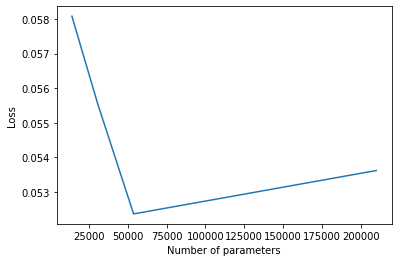

In [5]:
max_epochs = 1000
init_std = 0.1
loss_vec = []
num_params_vec = []
for rank in [10,15,20,40]:
  ranks = [1] + [rank] * (len(image.shape)-1) + [1]

  core_tensors = [torch.randn(ranks[i],image.shape[i],ranks[i+1])*init_std for i in range(len(ranks)-1)]
  num_params = np.sum([c.numel() for c in core_tensors])

  for c in core_tensors:
    c.requires_grad_(True)

  optim = torch.optim.RMSprop(core_tensors,lr=0.01)
  for epoch in range(max_epochs):
      loss = compute_completion_loss(tl.mps_to_tensor(core_tensors).reshape(image.shape), data)

      optim.zero_grad()
      loss.backward()
      optim.step()
      if False and epoch%100 == 0:
        print(f"epoch {epoch}: loss is {float(loss)}")
      
  recovered_image = tl.mps_to_tensor(core_tensors).reshape(image.shape).detach()
  total_loss = 1/recovered_image.numel() * torch.dist(recovered_image,image)
  print(f"final training loss: {loss}\ttotal loss (whole image): {total_loss}\tnumber of parameters: {num_params}")
  plt.imshow(recovered_image/255)
  plt.title(f"rank: {rank}")
  plt.show()
  loss_vec.append(total_loss)
  num_params_vec.append(num_params)
plt.plot(num_params_vec, loss_vec)
plt.xlabel('Number of parameters')
plt.ylabel('Loss')
plt.show()

As we have discussed in class, tensor train is espeically benificial when the tensor have many dimension. In this question, we will assume that the tensor to be recovered is of shape `[4, 4, 4, 2, 4, 4,  4,  2, 3]`, that is you need to initialize your tensor train w.r.t this new shape and then do the TT completion w.r.t this structure as well. Explore various TT rank and plot the relationship between the loss and number of parameters of the constructed TT structure. In addition, plot the completed images for each rank you have tried.
 
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.14017893373966217	total loss (whole image): 0.08626838028430939	number of parameters: 2470


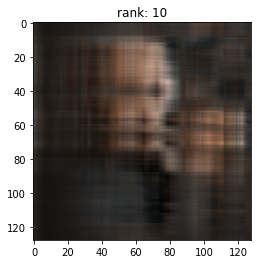

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.13493146002292633	total loss (whole image): 0.06079050526022911	number of parameters: 5505


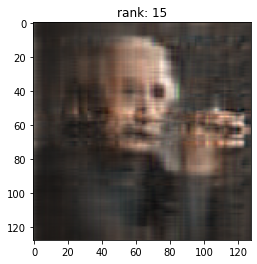

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.06746846437454224	total loss (whole image): 0.059575892984867096	number of parameters: 9740


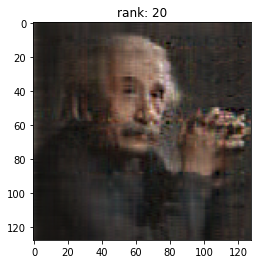

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.14087265729904175	total loss (whole image): 0.0523497611284256	number of parameters: 38680


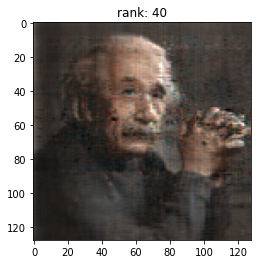

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


final training loss: 0.04339152202010155	total loss (whole image): 0.08986249566078186	number of parameters: 86820


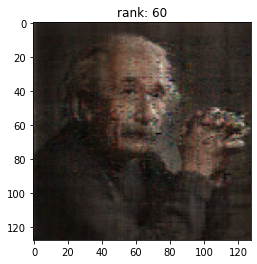

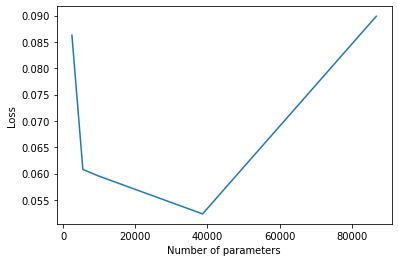

In [6]:
max_epochs = 2000
init_std = 0.1

tensor_shape = [4,4,4,2,4,4,4,2,3]
loss_vec = []
num_params_vec = []
for rank in [10,15,20,40,60]:
  ranks = [1] + [rank] * (len(tensor_shape)-1) + [1]

  core_tensors = [torch.randn(ranks[i],tensor_shape[i],ranks[i+1])*init_std for i in range(len(ranks)-1)]
  num_params = np.sum([c.numel() for c in core_tensors])
  for c in core_tensors:
    c.requires_grad_(True)

  optim = torch.optim.RMSprop(core_tensors,lr=0.01)
  for epoch in range(max_epochs):
      loss = compute_completion_loss(tl.mps_to_tensor(core_tensors).reshape(image.shape), data)

      optim.zero_grad()
      loss.backward()
      optim.step()
      if False and epoch%100 == 0:
        print(f"epoch {epoch}: loss is {float(loss)}")
      
  recovered_image = tl.mps_to_tensor(core_tensors).reshape(image.shape).detach()
  total_loss = 1/recovered_image.numel() * torch.dist(recovered_image,image)
  print(f"final training loss: {loss}\ttotal loss (whole image): {total_loss}\tnumber of parameters: {num_params}")
  plt.imshow(recovered_image/255)
  plt.title(f"rank: {rank}")
  plt.show()
  loss_vec.append(total_loss)
  num_params_vec.append(num_params)
plt.plot(num_params_vec, loss_vec)
plt.xlabel('Number of parameters')
plt.ylabel('Loss')
plt.show()